# **Clustering Earthquake Incidences: Evaluating Algorithms for Optimal Pattern Recognition**

A study by Serhet Gökdemir [Click Here For Further Information About Me](https://serhetgokdemir.github.io)
## **Chapters**<br>

**1. Introduction and Libraries**<br>
**2. Exploratory Data Analysis**<br>
**3. Data Preparation**<br>
**4. k-Means Algorithm**<br>
**5. Other Clustering Algorithms**<br>
*   5.1. Gaussian Mixture Model<br>
*   5.2. Agglomerative Clustering<br>
*   5.3. DBSCAN<br>

**6. Internal and External Metrics**<br>
*   6.1 For k-Means<br>
*   6.2 For GMM<br>
*   6.3 For DBSCAN<br>

**7. Final Choice of the Optimal Clustering Algorithm**<br>
**8. Results on the World Map**<br>
**9. Conclusion**<br>


## **1. Introduction**

This study employs clustering algorithms to analyze a dataset of earthquake occurrences characterized by focal depth, geographic coordinates, and Richter scale magnitudes. Our primary goal is to identify distinct clusters that reveal seismic activity patterns across various regions.

We will use the k-Means clustering algorithm and its mini-batch variant to determine the optimal number of clusters and explore data groupings. The efficacy of these methods will be assessed using both internal and external evaluation metrics to see how well the clusters align with recognized seismic patterns.

Moreover, this research will advance into more sophisticated clustering techniques, adjusting hyperparameters to refine our analysis. Ultimately, this work aims to deepen our understanding of earthquake distributions and contribute a structured approach to seismological research.

### Libraries

In [320]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import (
    KMeans, MiniBatchKMeans,
    AgglomerativeClustering, DBSCAN
)

from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    adjusted_rand_score, mutual_info_score, v_measure_score, fowlkes_mallows_score
)

## **2. Exploratory Data Analysis**

Firstly we need to set up the enviroment.

In [321]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/Colab Notebooks/Clustering/quake.csv"
df = pd.read_csv(file_path, delimiter=',')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's check the characteristics of the data.

In [322]:
df.shape

(2178, 4)

In [323]:
df.dtypes

,0
Focal depth,int64
Latitude,float64
Longitude,float64
Richter,float64


In [324]:
df.isna().sum()

,0
Focal depth,0
Latitude,0
Longitude,0
Richter,0


In [325]:
display(df.min(), df.max())

,0
Focal depth,0.00
Latitude,-66.49
Longitude,-179.96
Richter,5.80


,0
Focal depth,656.00
Latitude,78.15
Longitude,180.00
Richter,6.90


In [326]:
display(df.head())

,Focal depth,Latitude,Longitude,Richter
0,33,-52.26,28.30,6.70
1,36,45.53,150.93,5.80
2,57,41.85,142.78,5.80
3,67,29.19,141.15,6.20
4,30,-21.66,169.81,6.00


In [327]:
pd.options.display.float_format = '{:.2f}'.format
display(df.describe())

,Focal depth,Latitude,Longitude,Richter
count,2178.00,2178.00,2178.00,2178.00
mean,74.36,7.96,54.91,5.98
std,116.47,30.55,118.88,0.19
min,0.00,-66.49,-179.96,5.80
25%,21.00,-12.43,-67.78,5.80
50%,39.00,0.21,122.10,5.90
75%,68.00,36.48,146.86,6.10
max,656.00,78.15,180.00,6.90


I do not sense any outliers or problematic columns here.

## **3. Data Preparation**

In [328]:
df.isnull().sum()

,0
Focal depth,0
Latitude,0
Longitude,0
Richter,0


In [329]:
df.duplicated().sum()

1

We have 1 duplicates. This may should not be dropped (I don't have enough domain knowledge for this) but I am going to drop it.

In [330]:
duplicates = df[df.duplicated()]
display(duplicates.head())
df = df.drop_duplicates(keep = "last")

,Focal depth,Latitude,Longitude,Richter
1994,0,49.87,78.97,5.90


In [331]:
df.duplicated().sum()

0

I am going to scale the data but before this I need to detect outliers. I prefer z-score method because it requires less coding.

In [332]:
z_scores = np.abs(zscore(df))
outliers = (z_scores > 3)
outliers_rows = df[(z_scores > 3).any(axis=1)]
display(outliers_rows.head())
display(outliers_rows.tail())

,Focal depth,Latitude,Longitude,Richter
0,33,-52.26,28.30,6.70
77,585,-7.17,123.86,5.80
86,607,-4.34,122.14,5.80
87,578,-27.46,-63.23,5.80
140,40,53.03,-167.55,6.70


,Focal depth,Latitude,Longitude,Richter
2105,613,-9.21,-71.22,5.90
2132,629,-21.00,-178.99,6.10
2150,595,-7.08,124.28,5.80
2161,441,26.96,140.48,5.80
2175,527,27.87,139.51,5.80


In [333]:
df_no_outliers = df[(z_scores <= 3).all(axis=1)]

print("The number of rows in the data now:", len(df_no_outliers))

df = df_no_outliers

The number of rows in the data now: 2066


In [334]:
df.shape

(2066, 4)

We got rid of nearly 100 values. This is very important because for example, k-Means Algorithm is very sensitive to outliers and some other algorithms sensitive, too.<br>Now we can continue scaling.

In [335]:
scaler = MinMaxScaler()

df_backup = df
df = scaler.fit_transform(df)

display(df[:5])

array([[0.08530806, 0.77447456, 0.91926656, 0.        ],
       [0.13507109, 0.74903208, 0.89662453, 0.        ],
       [0.15876777, 0.66150442, 0.89209612, 0.57142857],
       [0.07109005, 0.30994192, 0.97171829, 0.28571429],
       [0.        , 0.61933075, 0.8349493 , 0.57142857]])

Now I will use PCA and reduce the data into 2 dimensions. It is for using plots more efficiently

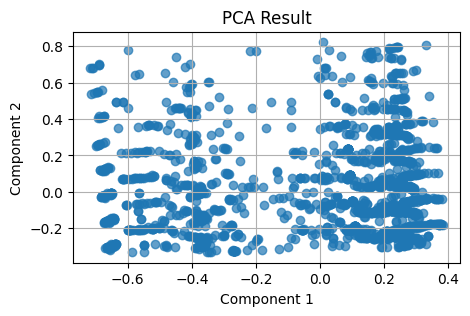

In [336]:
pca = PCA(n_components=2)
df_reduced = pca.fit_transform(df)

df_pca = pd.DataFrame(df_reduced, columns=['Component1', 'Component2'])

plt.figure(figsize=(5, 3))
plt.scatter(df_pca['Component1'], df_pca['Component2'], alpha=0.7)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA Result')
plt.grid(True)
plt.show()

In [337]:
print("Explained variance ratio:")
print(pca.explained_variance_ratio_)
print("Total explained variance:", pca.explained_variance_ratio_.sum())

Explained variance ratio:
[0.45988561 0.27186176]
Total explained variance: 0.7317473703471954


The two components explain a total of 73.17% of the variance, proving that PCA is sufficient for this data set. As a rule of thumb, an explanation of >70% is considered acceptable for most analyses.

## **4. k-Means Algorithm**

Firstly we build k-Means model with 15 clusters.

In [338]:
kmeans = KMeans(n_clusters=15, random_state=0)
clusters = kmeans.fit_predict(df_pca)

print("Cluster Centers:")
print(kmeans.cluster_centers_)

Cluster Centers:
[[-0.39624517  0.25988188]
 [ 0.22655298 -0.10417724]
 [-0.34891087 -0.260052  ]
 [ 0.19442865  0.38506095]
 [ 0.15584356  0.68835332]
 [-0.62629651  0.06158243]
 [ 0.02486889  0.02509035]
 [-0.61239583 -0.21974245]
 [ 0.2932471  -0.03014423]
 [ 0.06060979 -0.21463068]
 [ 0.26083368 -0.232698  ]
 [-0.5348397   0.51942808]
 [ 0.23332788  0.05868414]
 [-0.36486146 -0.04042483]
 [ 0.20516948  0.20193758]]


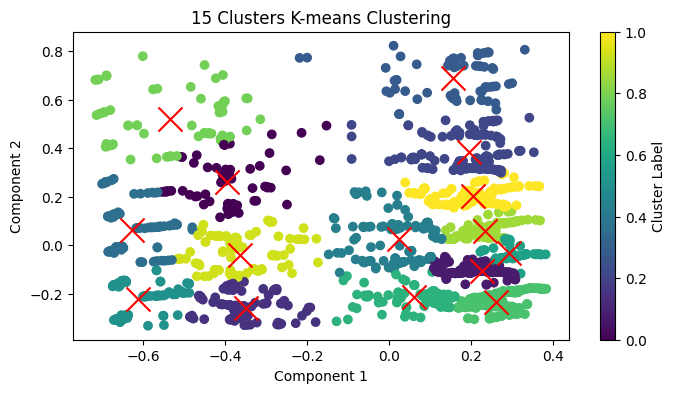

In [339]:
plt.figure(figsize=(8, 4))
plt.scatter(df_pca['Component1'], df_pca['Component2'], c=clusters, cmap='viridis', marker='o')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='x')
plt.title('15 Clusters K-means Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

Now we will sketch the Elbow Graph and Silhouette Score. Then decide the ideal cluster count.

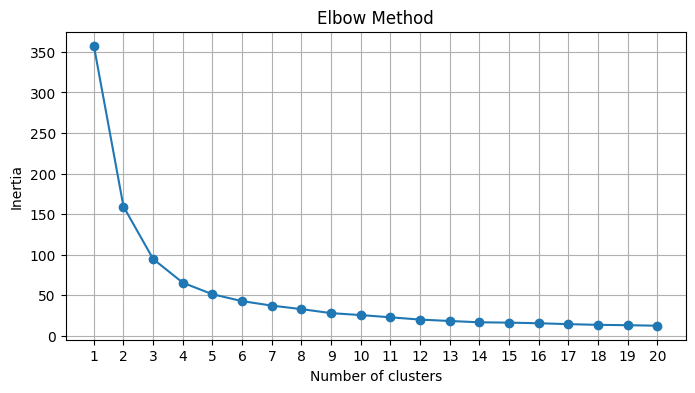

In [340]:
inertia = []
k_range = range(1, 21)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

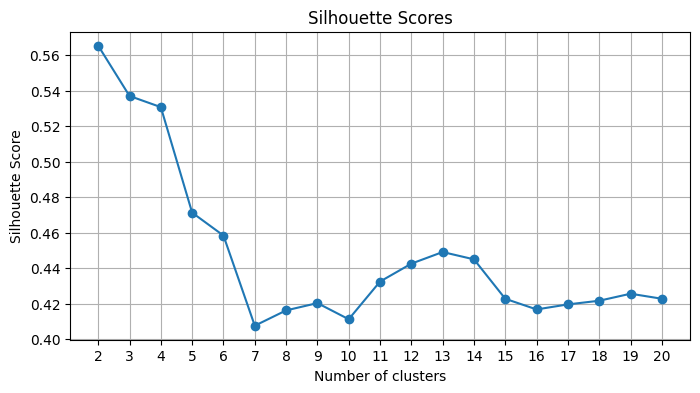

In [341]:
silhouette_scores = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(df_pca)
    score = silhouette_score(df_pca, clusters)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 4))
plt.plot(range(2, 21), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 21))
plt.grid(True)
plt.show()


According to Elbow Test and Silhouette Scores, 2, 3 and 4 look as the best options. I will try both then choose the cluster number.

Cluster Centers:
[[-0.47141639 -0.01810574]
 [ 0.20352905  0.00781696]]


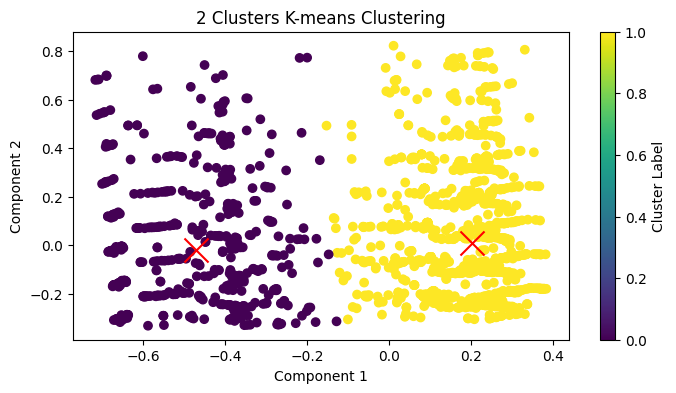

In [342]:
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(df_pca)

print("Cluster Centers:")
print(kmeans.cluster_centers_)

plt.figure(figsize=(8, 4))
plt.scatter(df_pca['Component1'], df_pca['Component2'], c=clusters, cmap='viridis', marker='o')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='x')
plt.title('2 Clusters K-means Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


Cluster Centers:
[[ 0.1666978   0.36629015]
 [ 0.20999403 -0.11769042]
 [-0.4742463  -0.03313853]]


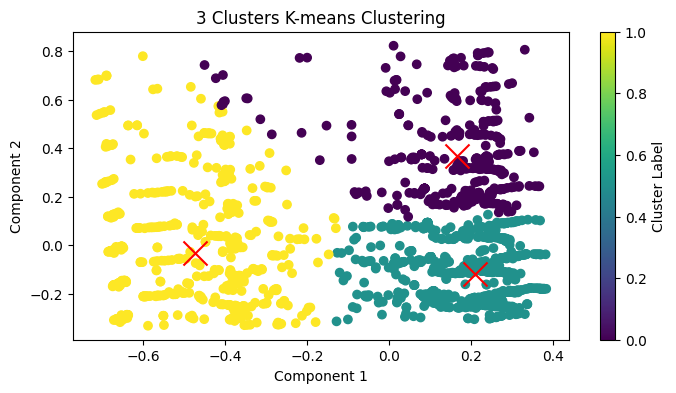

In [343]:
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(df_pca)

print("Cluster Centers:")
print(kmeans.cluster_centers_)

plt.figure(figsize=(8, 4))
plt.scatter(df_pca['Component1'], df_pca['Component2'], c=clusters, cmap='viridis', marker='o')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='x')
plt.title('3 Clusters K-means Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


Cluster Centers:
[[-0.5005422   0.31174785]
 [ 0.20996282 -0.11755869]
 [-0.45905619 -0.16769191]
 [ 0.18484156  0.35516852]]


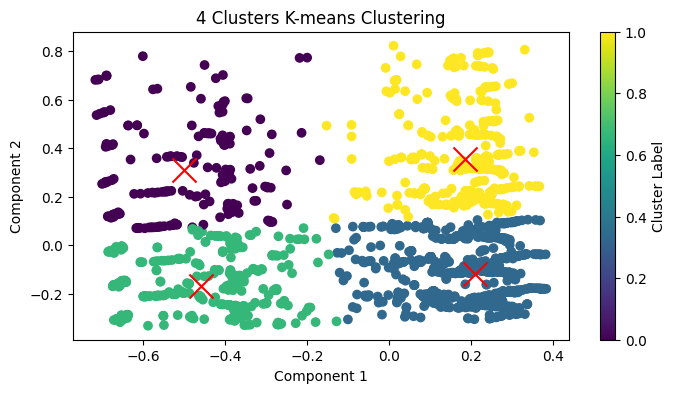

In [344]:
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(df_pca)

print("Cluster Centers:")
print(kmeans.cluster_centers_)

plt.figure(figsize=(8, 4))
plt.scatter(df_pca['Component1'], df_pca['Component2'], c=clusters, cmap='viridis', marker='o')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='x')
plt.title('4 Clusters K-means Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


4 looks like the optimal one, according to see. They look remarkably better than 15-cluster option, by the way.<br>
Now let's try Mini-Batch and compare the results.

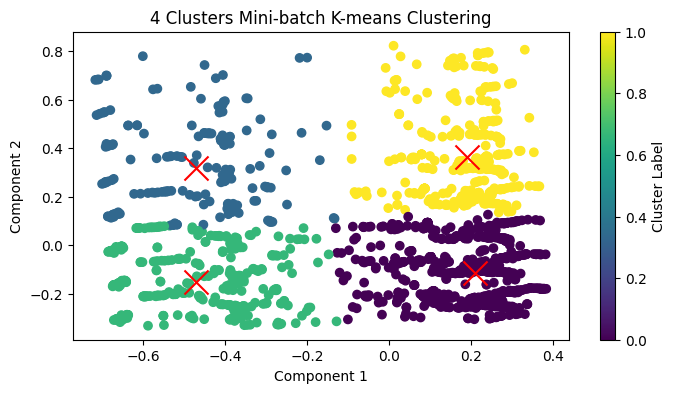

In [345]:
mini_kmeans = MiniBatchKMeans(n_clusters=4, random_state=0, batch_size=100)
mini_clusters = mini_kmeans.fit_predict(df_pca)

plt.figure(figsize=(8, 4))
plt.scatter(df_pca['Component1'], df_pca['Component2'], c=mini_clusters, cmap='viridis', marker='o')
plt.scatter(mini_kmeans.cluster_centers_[:, 0], mini_kmeans.cluster_centers_[:, 1], s=300, c='red', marker='x')
plt.title('4 Clusters Mini-batch K-means Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


Result:<br>

* In terms of clustering quality, both methods provided similar results, and the clusters obtained with the mini-batch method had a structure very close to those obtained with standard k-means. For small and medium-sized datasets like we use, the stability and consistency brought by the standard k-means method may make this method preferable.

## **5. Other Clustering Algorithms**

### 5.1. Gaussian Mixture Model (GMM)

`covariance_type='tied'` makes GMM run faster and allows the model to learn clusters more simply. This case assumes to clusters have a similar shape and variance. In our data, they have similiar shapes.<br>
Moreover, I set the cluster number as 3 this time because it gives better result.

Gaussian Mixture Cluster Means:
[[ 0.18304536  0.43921372]
 [ 0.20579279 -0.06279492]
 [-0.47266181 -0.0219092 ]]


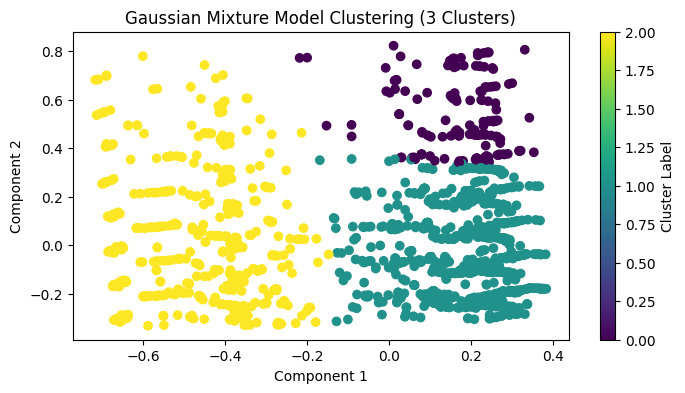

In [346]:
gmm = GaussianMixture(n_components=3, covariance_type='tied', random_state=0)
gmm_clusters = gmm.fit_predict(df_pca)

print("Gaussian Mixture Cluster Means:")
print(gmm.means_)

plt.figure(figsize=(8, 4))
plt.scatter(df_pca['Component1'], df_pca['Component2'], c=gmm_clusters, cmap='viridis', marker='o')
plt.title('Gaussian Mixture Model Clustering (3 Clusters)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


### 5.2 Agglomerative Clustering

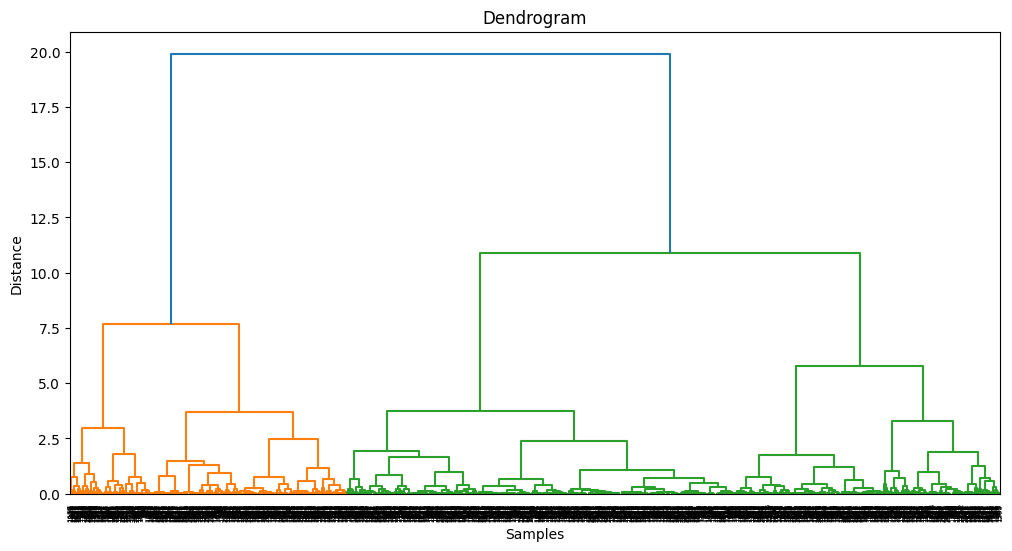

In [347]:
linkage_matrix = linkage(df_pca, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()


Based on the chart, splitting into 3 or 4 clusters seems reasonable. At this point we can choose the optimal number of clusters by drawing a horizontal cutting line. I tried both and 4 clusters seems better.

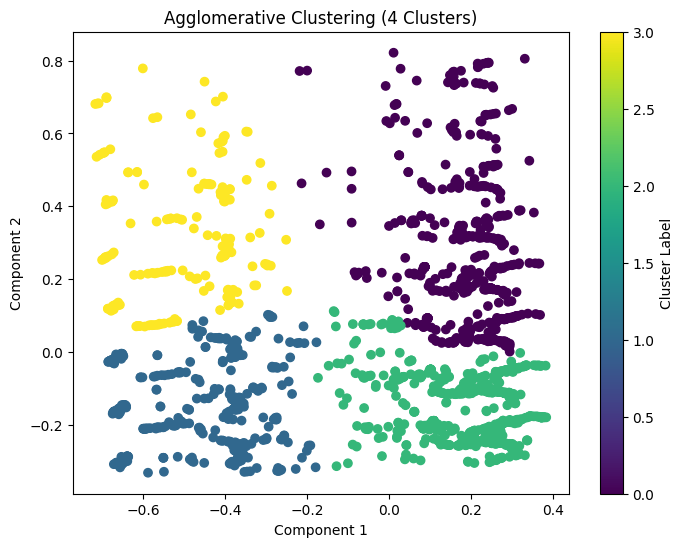

In [348]:
agg_cluster = AgglomerativeClustering(n_clusters=4, linkage='ward')
agg_clusters = agg_cluster.fit_predict(df_pca)

plt.figure(figsize=(8, 6))
plt.scatter(df_pca['Component1'], df_pca['Component2'], c=agg_clusters, cmap='viridis', marker='o')
plt.title('Agglomerative Clustering (4 Clusters)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


### 5.3 DBSCAN

Unique cluster labels (including noise): {0}
Number of noise points: 0


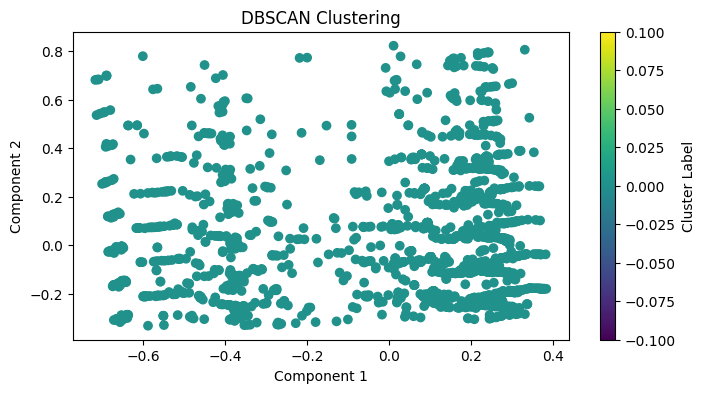

In [349]:
dbscan = DBSCAN(eps=0.5, min_samples=3)
dbscan_clusters = dbscan.fit_predict(df_pca)

unique_labels = set(dbscan_clusters)
print(f"Unique cluster labels (including noise): {unique_labels}")

noise_points = sum(dbscan_clusters == -1)
print(f"Number of noise points: {noise_points}")

plt.figure(figsize=(8, 4))
plt.scatter(df_pca['Component1'], df_pca['Component2'], c=dbscan_clusters, cmap='viridis', marker='o')
plt.title('DBSCAN Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


It gave a failed output even with eps=1 and min_samples=1! According to my research on the internet, it may be because of PCA.<br>

This problem can be solved by using unscaled version of our data but we had good results with other algorithms already.

## **6. Internal and External Metrics**

**!! According to instructions, as ground truth for external metrics, cluster labels from K-Means were used.**

### 6.1 For k-Means

In [350]:
clusters = kmeans.labels_

kmeans_labels = kmeans.labels_

silhouette = silhouette_score(df_pca, clusters)
calinski_harabasz = calinski_harabasz_score(df_pca, clusters)
davies_bouldin = davies_bouldin_score(df_pca, clusters)

print("K-Means Internal Measures:")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")

adj_ri = adjusted_rand_score(kmeans_labels, clusters)
mi = mutual_info_score(kmeans_labels, clusters)
v_measure = v_measure_score(kmeans_labels, clusters)
fowlkes_mallows = fowlkes_mallows_score(kmeans_labels, clusters)

print("\nK-Means External Measures:")
print(f"Adjusted Rand Index (adjRI): {adj_ri:.4f}")
print(f"Mutual Information: {mi:.4f}")
print(f"V-Measure: {v_measure:.4f}")
print(f"Fowlkes-Mallows Score: {fowlkes_mallows:.4f}")

K-Means Internal Measures:
Silhouette Score: 0.5307
Calinski-Harabasz Index: 3084.3914
Davies-Bouldin Index: 0.7316

K-Means External Measures:
Adjusted Rand Index (adjRI): 1.0000
Mutual Information: 1.2030
V-Measure: 1.0000
Fowlkes-Mallows Score: 1.0000


**1. Internal Measures (Cluster Quality):**
_____________________________
**a-) Silhouette Score (0.5307):**<br>
This score indicates moderate-to-good clustering performance. There is sufficient separation between clusters and cohesion within clusters.<br><br>
**b-) Calinski-Harabasz Index (3084.3914):**<br>
A very high value, suggesting strong separation between clusters and tightness within clusters.<br><br>
**c-) Davies-Bouldin Index (0.7316):**<br>
A low value, indicating that inter-cluster distances are significantly larger than intra-cluster distances.<br><br>

**2. External Measures (Reference-Based Evaluation):**
_______________________
**Adjusted Rand Index (adjRI - 1.0000):**<br>
Perfect alignment with the K-Means own cluster labels, as expected when using it as the ground truth.<br><br>
**Mutual Information (1.2030):**<br>
High information overlap between clusters.<br><br>
**V-Measure (1.0000):**<br>
The clusters are completely homogeneous and complete.<br><br>
**Fowlkes-Mallows Score (1.0000):**<br>
The clustering is completely accurate and without errors.<br>

* K-Means generally performs well. On the other hand, the good performance in external measures was expected since K-Means was used as the ground truth.

* In terms of internal metrics, the algorithm also demonstrates strong clustering quality, with a reasonable Silhouette Score, high Calinski-Harabasz Index, and a low Davies-Bouldin Index. This indicates that K-Means is highly suitable for this dataset and can effectively identify meaningful clusters.

### 6.2 For GMM

In [351]:
clusters = gmm.predict(df_pca)
kmeans_labels = kmeans.labels_

silhouette = silhouette_score(df_pca, clusters)
calinski_harabasz = calinski_harabasz_score(df_pca, clusters)
davies_bouldin = davies_bouldin_score(df_pca, clusters)

print("GMM Internal Measures:")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")

adj_ri = adjusted_rand_score(kmeans_labels, clusters)
mi = mutual_info_score(kmeans_labels, clusters)
v_measure = v_measure_score(kmeans_labels, clusters)
fowlkes_mallows = fowlkes_mallows_score(kmeans_labels, clusters)

print("\nGMM External Measures:")
print(f"Adjusted Rand Index (adjRI): {adj_ri:.4f}")
print(f"Mutual Information: {mi:.4f}")
print(f"V-Measure: {v_measure:.4f}")
print(f"Fowlkes-Mallows Score: {fowlkes_mallows:.4f}")


GMM Internal Measures:
Silhouette Score: 0.5242
Calinski-Harabasz Index: 2364.3499
Davies-Bouldin Index: 0.6212

GMM External Measures:
Adjusted Rand Index (adjRI): 0.6637
Mutual Information: 0.7210
V-Measure: 0.6991
Fowlkes-Mallows Score: 0.8100


GMM performs well, particularly in internal measures where the Davies-Bouldin Index is notably better than K-Means, showing that GMM’s elliptical cluster boundaries fit the data better in some cases. However, external measures suggest that GMM does not align as strongly with K-Means ground truth labels, maybe except Fowlkes-Mallows.<br>
In conclusion, it may be preferable.

### 6.3 For Agglomerative Clustering

In [352]:
clusters = agg_clusters
kmeans_labels = kmeans.labels_

silhouette = silhouette_score(df_pca, clusters)
calinski_harabasz = calinski_harabasz_score(df_pca, clusters)
davies_bouldin = davies_bouldin_score(df_pca, clusters)

print("Agglomerative Clustering Internal Measures:")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")

adj_ri = adjusted_rand_score(kmeans_labels, clusters)
mi = mutual_info_score(kmeans_labels, clusters)
v_measure = v_measure_score(kmeans_labels, clusters)
fowlkes_mallows = fowlkes_mallows_score(kmeans_labels, clusters)

print("\nAgglomerative Clustering External Measures:")
print(f"Adjusted Rand Index (adjRI): {adj_ri:.4f}")
print(f"Mutual Information: {mi:.4f}")
print(f"V-Measure: {v_measure:.4f}")
print(f"Fowlkes-Mallows Score: {fowlkes_mallows:.4f}")

Agglomerative Clustering Internal Measures:
Silhouette Score: 0.4825
Calinski-Harabasz Index: 2799.3174
Davies-Bouldin Index: 0.7778

Agglomerative Clustering External Measures:
Adjusted Rand Index (adjRI): 0.7146
Mutual Information: 0.9713
V-Measure: 0.7874
Fowlkes-Mallows Score: 0.8095


Agglomerative Clustering performs reasonably well but does not outperform K-Means or GMM in most metrics

## **7. Final Choice of the Optimal Clustering Algorithm**

Final Choice of Best Clustering Algorithm
Based on the internal and external metrics evaluated for K-Means, GMM, Agglomerative Clustering, and DBSCAN (not applicable actually), the best clustering algorithm should be chosen by weighing the following factors:

Internal Metrics:<br>
* K-Means demonstrated the highest Calinski-Harabasz Index and a good Davies-Bouldin Index, indicating strong inter-cluster separation and intra-cluster cohesion.
GMM excelled in the Davies-Bouldin Index, showcasing its flexibility in modeling elliptical clusters.<br><br>
___________
External Metrics:<br>
* K-Means achieved perfect scores in external measures due to its use as the ground truth. GMM and Agglomerative Clustering also showed reasonable alignment with K-Means labels but performed slightly worse.
____________
Overall Performance:<br>
* K-Means is the most consistent across metrics and computationally efficient, making it the best choice for this dataset.<br>
______________
Conclusion:<br>
K-Means was selected as the best clustering algorithm due to its:<br>
* Consistent performance across both internal and external metrics.
* Straightforward implementation and interpretability.
* Strong ability to separate distinct clusters within the dataset.


## **8. Results on the World Map**

It was not possible to use the data on map after apply scaling and dimensionality reduction techniques. So I used the original version of the data.<br>

The above map illustrates the geographical clustering of earthquakes based on the K-Means algorithm. Each cluster, represented by a unique color, identifies regions with similar seismic activity patterns. For example, high activity is observed along the Pacific Ring of Fire and the Mediterranean region.<br>

"I live in Southeastern Turkey and have personally experienced some of these devastating earthquakes, unfortunately. Moreover, it seems that the data was collected before 2023, as a terrible earthquake occurred in Kahramanmaraş, Turkey, causing nearly 200,000 deaths and affected also Syria.

In [353]:
latitude = df_backup['Latitude']
longitude = df_backup['Longitude']

m = folium.Map(location=[latitude.mean(), longitude.mean()], zoom_start=5)

colors = ['red', 'blue', 'green', 'purple']

for lat, lon, cluster in zip(latitude, longitude, clusters):
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        color=colors[cluster % len(colors)],
        fill=True,
        fill_color=colors[cluster % len(colors)],
        fill_opacity=0.6
    ).add_to(m)

m.save("clustering_results_map.html")
m


## **9. Conclusion**

In this project, we analyzed earthquake data and grouped similar events using clustering methods. After preparing the data and exploring its structure, we applied several clustering algorithms, including K-Means, Gaussian Mixture Model (GMM), Agglomerative Clustering, and DBSCAN. The quality of each algorithm was evaluated with internal and external metrics.<br><br>

The results showed that K-Means performed the best overall. It produced well-separated clusters and had high scores in most evaluation metrics. GMM and Agglomerative Clustering also gave good results, but they were slightly less accurate compared to K-Means. DBSCAN did not perform well with the scaled data, likely due to the nature of the dataset.<br><br>

Finally, the clustering results were visualized on a world map to show how earthquake events are distributed globally. This analysis helped identify patterns in seismic activity, such as active regions along tectonic plate boundaries. The findings can provide useful insights for understanding earthquake behavior and planning further studies.